# Volkswagen Stock Price

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sn
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.stattools as sts
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings('ignore')
sns.set()

### Importing the Data

In [2]:
raw_data = yfinance.download(tickers = "VOW.DE, PAH3.DE, BMW.DE", interval = '1d', group_by = 'ticker', 
                             auto_adjust=True, treads=True)
df = raw_data.copy()

[*********************100%***********************]  3 of 3 completed


In [3]:
df.head()

PAH3.DE                           VOW.DE                        \
              Open High Low Close Volume       Open       High        Low   
Date                                                                        
1995-03-29     NaN  NaN NaN   NaN    NaN  10.457071  10.457071  10.457071   
1995-03-30     NaN  NaN NaN   NaN    NaN  10.441512  10.814453  10.441512   
1995-03-31     NaN  NaN NaN   NaN    NaN  10.783335  10.783335  10.783335   
1995-04-03     NaN  NaN NaN   NaN    NaN  10.783335  10.783335  10.783335   
1995-04-04     NaN  NaN NaN   NaN    NaN  10.783335  10.783335  10.783335   

                             BMW.DE                        
                Close Volume   Open High Low Close Volume  
Date                                                       
1995-03-29  10.457071      0    NaN  NaN NaN   NaN    NaN  
1995-03-30  10.783335     10    NaN  NaN NaN   NaN    NaN  
1995-03-31  10.783335      0    NaN  NaN NaN   NaN    NaN  
1995-04-03  10.783335      0    NaN  NaN NaN   NaN    NaN  
1995-04-04  10.783335      0    NaN  NaN NaN   NaN    NaN

In [4]:
df.tail()

PAH3.DE                                                  VOW.DE  \
                 Open       High        Low      Close     Volume        Open   
Date                                                                            
2022-11-07  56.599998  59.000000  56.500000  58.320000   790628.0  172.449997   
2022-11-08  58.439999  59.180000  57.340000  57.340000   696449.0  181.600006   
2022-11-09  57.340000  58.279999  56.320000  57.180000   632150.0  178.949997   
2022-11-10  56.860001  58.680000  56.020000  58.660000  1246970.0  178.000000   
2022-11-11  59.400002  61.180000  59.279999  59.759998  1668596.0  185.000000   

                                                          BMW.DE             \
                  High         Low       Close Volume       Open       High   
Date                                                                          
2022-11-07  182.000000  172.000000  181.149994  41232  79.529999  81.139999   
2022-11-08  182.399994  179.750000  180.149994  27414  81.000000  81.190002   
2022-11-09  181.199997  177.699997  179.750000  28914  80.790001  80.870003   
2022-11-10  184.899994  176.850006  184.300003  46332  80.000000  83.300003   
2022-11-11  191.399994  184.750000  190.500000  40191  83.730003  84.330002   

                                             
                  Low      Close     Volume  
Date                                         
2022-11-07  79.209999  81.029999  1351929.0  
2022-11-08  80.389999  80.489998  1326961.0  
2022-11-09  79.370003  80.250000  1161232.0  
2022-11-10  79.900002  82.849998  1726552.0  
2022-11-11  83.260002  84.239998  1457198.0

### Defining Key Dates

In [5]:
start_date = '2009-04-05'
date1 = '2009-12-09'
date2 = '2012-07-05'
end_date = '2014-01-01'
diseal_gate = '2015-09-20'

### Pre-Processing the data

In [7]:
#Extracting Closing Prices
df['vol'] = df['VOW.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

In [9]:
#Creating Returns
df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

In [10]:
#Creating squared returns
df['sq_ret_vol'] = df.ret_vol.mul(df.ret_vol)
df['sq_ret_por'] = df.ret_por.mul(df.ret_por)
df['sq_ret_bmw'] = df.ret_bmw.mul(df.ret_bmw)

In [13]:
#Extracting Volume
df['q_vol'] = df['VOW.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

In [14]:
df.tail()

PAH3.DE                                                  VOW.DE  \
                 Open       High        Low      Close     Volume        Open   
Date                                                                            
2022-11-07  56.599998  59.000000  56.500000  58.320000   790628.0  172.449997   
2022-11-08  58.439999  59.180000  57.340000  57.340000   696449.0  181.600006   
2022-11-09  57.340000  58.279999  56.320000  57.180000   632150.0  178.949997   
2022-11-10  56.860001  58.680000  56.020000  58.660000  1246970.0  178.000000   
2022-11-11  59.400002  61.180000  59.279999  59.759998  1668596.0  185.000000   

                                                       ...        bmw  \
                  High         Low       Close Volume  ...              
Date                                                   ...              
2022-11-07  182.000000  172.000000  181.149994  41232  ...  81.029999   
2022-11-08  182.399994  179.750000  180.149994  27414  ...  80.489998   
2022-11-09  181.199997  177.699997  179.750000  28914  ...  80.250000   
2022-11-10  184.899994  176.850006  184.300003  46332  ...  82.849998   
2022-11-11  191.399994  184.750000  190.500000  40191  ...  84.239998   

             ret_vol   ret_por   ret_bmw sq_ret_vol sq_ret_por sq_ret_bmw  \
                                                                            
Date                                                                        
2022-11-07  4.109192  1.958040  1.541348  16.885458   3.833921   2.375754   
2022-11-08 -0.552029 -1.680383 -0.666421   0.304736   2.823688   0.444117   
2022-11-09 -0.222034 -0.279037 -0.298171   0.049299   0.077862   0.088906   
2022-11-10  2.531295  2.588317  3.239873   6.407455   6.699384  10.496780   
2022-11-11  3.364079  1.875210  1.677730  11.317025   3.516414   2.814778   

            q_vol      q_por      q_bmw  
                                         
Date                                     
2022-11-07  41232   790628.0  1351929.0  
2022-11-08  27414   696449.0  1326961.0  
2022-11-09  28914   632150.0  1161232.0  
2022-11-10  46332  1246970.0  1726552.0  
2022-11-11  40191  1668596.0  1457198.0  

[5 rows x 27 columns]

In [15]:
# Assigning frequency
df = df.asfreq('b')
df = df.fillna(method='bfill')

In [16]:
del df['VOW.DE']
del df['PAH3.DE']
del df['BMW.DE']

In [17]:
df.tail()

,vol,por,bmw,ret_vol,ret_por,ret_bmw,sq_ret_vol,sq_ret_por,sq_ret_bmw,q_vol,q_por,q_bmw
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2022-11-07,181.149994,58.320000,81.029999,4.109192,1.958040,1.541348,16.885458,3.833921,2.375754,41232.0,790628.0,1351929.0
2022-11-08,180.149994,57.340000,80.489998,-0.552029,-1.680383,-0.666421,0.304736,2.823688,0.444117,27414.0,696449.0,1326961.0
2022-11-09,179.750000,57.180000,80.250000,-0.222034,-0.279037,-0.298171,0.049299,0.077862,0.088906,28914.0,632150.0,1161232.0
2022-11-10,184.300003,58.660000,82.849998,2.531295,2.588317,3.239873,6.407455,6.699384,10.496780,46332.0,1246970.0,1726552.0
2022-11-11,190.500000,59.759998,84.239998,3.364079,1.875210,1.677730,11.317025,3.516414,2.814778,40191.0,1668596.0,1457198.0


In [19]:
df.isna().sum()

vol             0
por             0
bmw             0
ret_vol         0
ret_por         0
ret_bmw         0
sq_ret_vol      0
sq_ret_por      0
sq_ret_bmw      0
q_vol           0
q_por           0
q_bmw           0
dtype: int64

### Plotting the prices

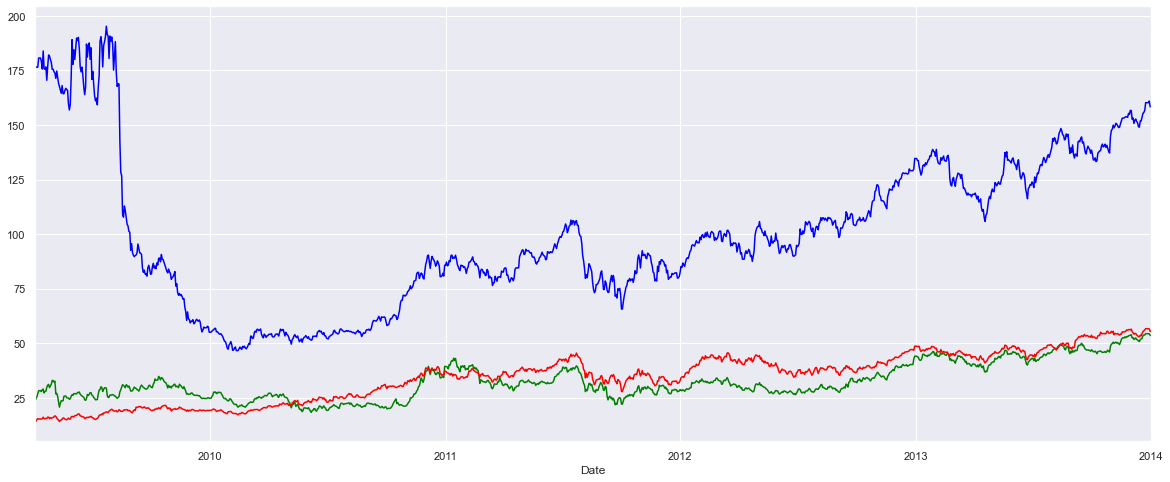

In [22]:
df['vol'][start_date:end_date].plot(figsize=(20,8), color="blue")
df['por'][start_date:end_date].plot(color="green")
df['bmw'][start_date:end_date].plot(color="red")
plt.show()

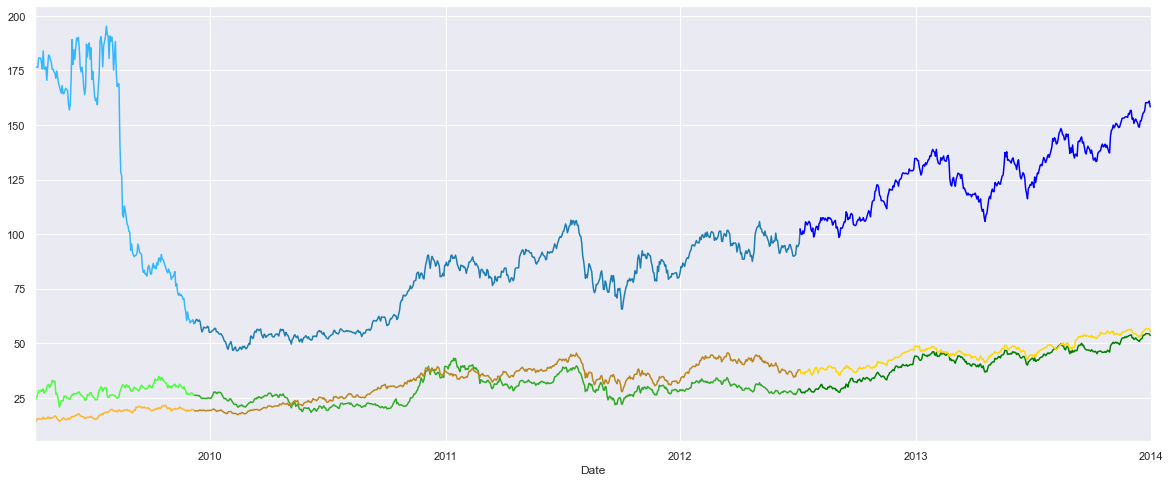

In [27]:
df['vol'][start_date:date1].plot(figsize=(20,8), color="#33B8FF")
df['por'][start_date:date1].plot(color="#49FF3A")
df['bmw'][start_date:date1].plot(color="#FEB628")

df['vol'][date1:date2].plot(color="#1E7EB2")
df['por'][date1:date2].plot(color="#2FAB25")
df['bmw'][date1:date2].plot(color="#BA861F")

df['vol'][date2:end_date].plot(color="blue")
df['por'][date2:end_date].plot(color="green")
df['bmw'][date2:end_date].plot(color="gold")
plt.show()

### Correlation

In [32]:
print('Correlation among manufacturers from ' + str(start_date)+ ' to '+ str(end_date) + '\n')
print('Volkswagen  & Porsche correlation : \t' + str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('Volkswagen  & BMW correlation : \t' + str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('BMW  & Porsche correlation : \t' + str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

Correlation among manufacturers from 2009-04-05 to 2014-01-01

Volkswagen  & Porsche correlation : 	0.5841635038609215
Volkswagen  & BMW correlation : 	0.33230970587193087
BMW  & Porsche correlation : 	0.8052157832977319


In [34]:
print('Correlation among manufacturers from ' + str(start_date)+ ' to '+ str(date1) + '\n')
print('Volkswagen  & Porsche correlation : \t' + str(df['vol'][start_date:date1].corr(df['por'][start_date:date1])))
print('Volkswagen  & BMW correlation : \t' + str(df['vol'][start_date:date1].corr(df['bmw'][start_date:date1])))
print('BMW  & Porsche correlation : \t' + str(df['por'][start_date:date1].corr(df['bmw'][start_date:date1])))

Correlation among manufacturers from 2009-04-05 to 2009-12-09

Volkswagen  & Porsche correlation : 	-0.5063924875772599
Volkswagen  & BMW correlation : 	-0.7689439395795256
BMW  & Porsche correlation : 	0.6095038895385956


In [35]:
print('Correlation among manufacturers from ' + str(date1)+ ' to '+ str(date2) + '\n')
print('Volkswagen  & Porsche correlation : \t' + str(df['vol'][date1:date2].corr(df['por'][date1:date2])))
print('Volkswagen  & BMW correlation : \t' + str(df['vol'][date1:date2].corr(df['bmw'][date1:date2])))
print('BMW  & Porsche correlation : \t' + str(df['por'][date1:date2].corr(df['bmw'][date1:date2])))

Correlation among manufacturers from 2009-12-09 to 2012-07-05

Volkswagen  & Porsche correlation : 	0.775915219093154
Volkswagen  & BMW correlation : 	0.9603532921057522
BMW  & Porsche correlation : 	0.7042723363962777


In [36]:
print('Correlation among manufacturers from ' + str(date2)+ ' to '+ str(end_date) + '\n')
print('Volkswagen  & Porsche correlation : \t' + str(df['vol'][date2:end_date].corr(df['por'][date2:end_date])))
print('Volkswagen  & BMW correlation : \t' + str(df['vol'][date2:end_date].corr(df['bmw'][date2:end_date])))
print('BMW  & Porsche correlation : \t' + str(df['por'][date2:end_date].corr(df['bmw'][date2:end_date])))

Correlation among manufacturers from 2012-07-05 to 2014-01-01

Volkswagen  & Porsche correlation : 	0.9627375580574881
Volkswagen  & BMW correlation : 	0.9520412427331795
BMW  & Porsche correlation : 	0.9494111636009629


### Auto Arima Model

#### For Volkswagen

In [51]:
mod_pr_pre_vol = auto_arima(df.vol[start_date:date1],
                            exogenous=df[['por','bmw']][start_date:date1],
                           m=5, max_p=5, max_q=5)
mod_pr_btn_vol = auto_arima(df.vol[date1:date2],
                            exogenous=df[['por','bmw']][date1:date2],
                           m=5, max_p=5, max_q=5)
mod_pr_post_vol =auto_arima(df.vol[date2:end_date],
                            exogenous=df[['por','bmw']][date2:end_date],
                           m=5, max_p=5, max_q=5)

In [52]:
mod_pr_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -547.206
Date:                Sun, 13 Nov 2022   AIC                           1098.413
Time:                        17:41:03   BIC                           1104.765
Sample:                    04-06-2009   HQIC                          1100.989
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.6647      0.403     -1.648      0.099      -1.455       0.126
sigma2        28.3676      1.631     17.393      0.000      25.171      31.564
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               182.78
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
mod_pr_btn_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1307.889
Date:                Sun, 13 Nov 2022   AIC                           2619.779
Time:                        17:41:05   BIC                           2628.796
Sample:                    12-09-2009   HQIC                          2623.271
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0924      0.035      2.643      0.008       0.024       0.161
sigma2         2.8876      0.113     25.496      0.000       2.666       3.110
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               116.02
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               5.38   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
mod_pr_post_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -805.424
Date:                Sun, 13 Nov 2022   AIC                           1614.848
Time:                        17:41:06   BIC                           1622.775
Sample:                    07-05-2012   HQIC                          1617.991
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1439      0.097      1.479      0.139      -0.047       0.335
sigma2         3.6808      0.198     18.543      0.000       3.292       4.070
===================================================================================
Ljung-Box (L1) (Q):                   1.77   Jarque-Bera (JB):                38.44
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                             0.04
Prob(H) (two-sided):                  0.16   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### For Porsche

In [55]:
mod_pr_pre_por = auto_arima(df.por[start_date:date1],
                            exogenous=df[['vol','bmw']][start_date:date1],
                           m=5, max_p=5, max_q=5)
mod_pr_btn_por = auto_arima(df.por[date1:date2],
                            exogenous=df[['vol','bmw']][date1:date2],
                           m=5, max_p=5, max_q=5)
mod_pr_post_por=auto_arima(df.por[date2:end_date],
                            exogenous=df[['vol','bmw']][date2:end_date],
                           m=5, max_p=5, max_q=5)

In [56]:
mod_pr_pre_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -251.149
Date:                Sun, 13 Nov 2022   AIC                            504.297
Time:                        17:41:21   BIC                            507.474
Sample:                    04-06-2009   HQIC                           505.586
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.0000      0.053     19.004      0.000       0.897       1.103
===================================================================================
Ljung-Box (L1) (Q):                   3.50   Jarque-Bera (JB):               319.80
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -1.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
mod_pr_btn_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -806.676
Date:                Sun, 13 Nov 2022   AIC                           1617.352
Time:                        17:41:24   BIC                           1626.370
Sample:                    12-09-2009   HQIC                          1620.845
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1096      0.032      3.457      0.001       0.047       0.172
sigma2         0.6482      0.020     32.054      0.000       0.609       0.688
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               483.16
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.15   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
mod_pr_post_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -407.475
Date:                Sun, 13 Nov 2022   AIC                            818.950
Time:                        17:41:27   BIC                            826.877
Sample:                    07-05-2012   HQIC                           822.092
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0640      0.035      1.824      0.068      -0.005       0.133
sigma2         0.4757      0.027     17.659      0.000       0.423       0.529
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):                25.52
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.14
Prob(H) (two-sided):                  0.97   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### For BMW

In [59]:
mod_pr_pre_bmw = auto_arima(df.bmw[start_date:date1],
                            exogenous=df[['vol','por']][start_date:date1],
                           m=5, max_p=5, max_q=5)
mod_pr_btn_bmw = auto_arima(df.bmw[date1:date2],
                            exogenous=df[['vol','por']][date1:date2],
                           m=5, max_p=5, max_q=5)
mod_pr_post_bmw=auto_arima(df.bmw[date2:end_date],
                            exogenous=df[['vol','por']][date2:end_date],
                           m=5, max_p=5, max_q=5)

In [60]:
mod_pr_pre_bmw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -93.020
Date:                Sun, 13 Nov 2022   AIC                            188.040
Time:                        17:42:19   BIC                            191.216
Sample:                    04-06-2009   HQIC                           189.328
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1675      0.016     10.355      0.000       0.136       0.199
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                 1.73
Prob(Q):                              0.57   Prob(JB):                         0.42
Heteroskedasticity (H):               0.92   Skew:                             0.14
Prob(H) (two-sided):                  0.73   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
mod_pr_btn_bmw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  672
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 5)   Log Likelihood                -738.561
Date:                            Sun, 13 Nov 2022   AIC                           1489.122
Time:                                    17:42:19   BIC                           1516.175
Sample:                                12-09-2009   HQIC                          1499.600
                                     - 07-05-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8177      0.029    -27.994      0.000      -0.875      -0.760
ar.L2         -0.9014      0.030    -29.818      0.000      -0.961      -0.842
ma.L1          0.8511      0.017     50.256      0.000       0.818       0.884
ma.L2          0.9689      0.018     55.230      0.000       0.935       1.003
ar.S.L5       -0.0752      0.038     -1.984      0.047      -0.149      -0.001
sigma2         0.5286      0.022     23.516      0.000       0.485       0.573
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                94.28
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               4.42   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
mod_pr_post_bmw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  390
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood                -371.914
Date:                             Sun, 13 Nov 2022   AIC                            749.829
Time:                                     17:42:19   BIC                            761.719
Sample:                                 07-05-2012   HQIC                           754.543
                                      - 01-01-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0458      0.030      1.538      0.124      -0.013       0.104
ma.S.L5       -0.0762      0.054     -1.406      0.160      -0.183       0.030
sigma2         0.3962      0.021     18.460      0.000       0.354       0.438
===================================================================================
Ljung-Box (L1) (Q):                   1.35   Jarque-Bera (JB):                44.11
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.00
Prob(H) (two-sided):                  0.83   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predictions / Forecast

#### without exogenous

In [64]:
mod_pr_pre_vol = auto_arima(df.vol[start_date:date1],
                           m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend = 'ct')
mod_pr_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -546.928
Date:                Sun, 13 Nov 2022   AIC                           1099.855
Time:                        17:48:18   BIC                           1109.384
Sample:                    04-06-2009   HQIC                          1103.720
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1446      1.105     -0.131      0.896      -2.311       2.022
drift         -0.0058      0.014     -0.404      0.686      -0.034       0.022
sigma2        28.2784      1.811     15.613      0.000      24.728      31.828
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               178.10
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
df_pr_pre_vol = pd.DataFrame(mod_pr_pre_vol.predict(n_periods=len(df[date1:date2])),
                            index=df[date1:date2].index)

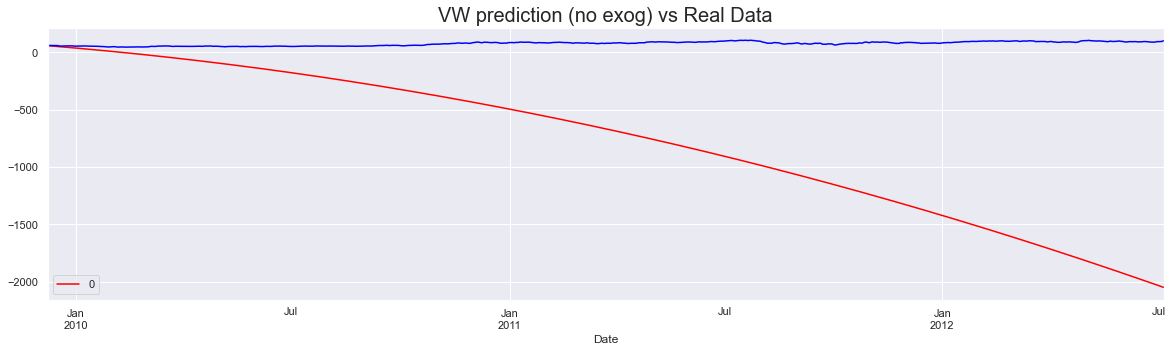

In [69]:
df_pr_pre_vol[date1:date2].plot(figsize=(20,5), color='red')
df.vol[date1:date2].plot(color='blue')
plt.title('VW prediction (no exog) vs Real Data', size = 20)
plt.show()

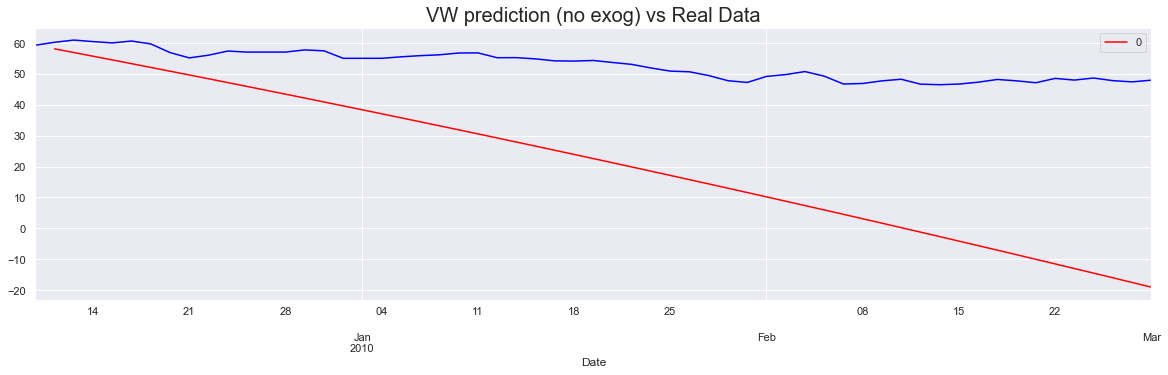

In [70]:
df_pr_pre_vol[date1:'2010-03-01'].plot(figsize=(20,5), color='red')
df.vol[date1:'2010-03-01'].plot(color='blue')
plt.title('VW prediction (no exog) vs Real Data', size = 20)
plt.show()

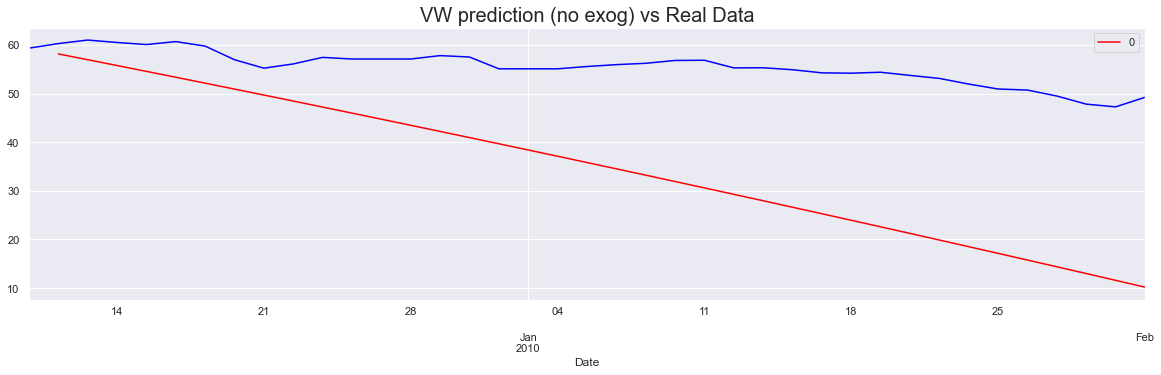

In [71]:
df_pr_pre_vol[date1:'2010-02-01'].plot(figsize=(20,5), color='red')
df.vol[date1:'2010-02-01'].plot(color='blue')
plt.title('VW prediction (no exog) vs Real Data', size = 20)
plt.show()

#### without exogenous on return values

In [92]:
mod_ret_pre_vol = auto_arima(df.ret_vol[start_date:date1],
                           m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend = 'ct')
mod_ret_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:                        SARIMAX   Log Likelihood                -477.378
Date:                Sun, 13 Nov 2022   AIC                            960.756
Time:                        18:21:44   BIC                            970.301
Sample:                    04-06-2009   HQIC                           964.627
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1908      0.648      0.294      0.769      -1.080       1.461
drift         -0.0081      0.007     -1.180      0.238      -0.022       0.005
sigma2        12.5028      0.871     14.347      0.000      10.795      14.211
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                73.67
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                            -0.39
Prob(H) (two-sided):                  0.30   Kurtosis:                         6.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [93]:
df_ret_pre_vol = pd.DataFrame(mod_ret_pre_vol.predict(n_periods=len(df[date1:date2])),
                            index=df[date1:date2].index)

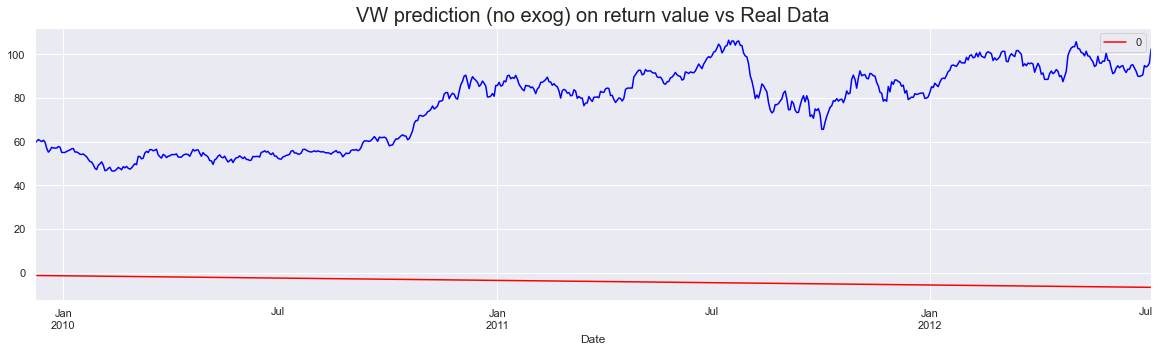

In [95]:
df_ret_pre_vol[date1:date2].plot(figsize=(20,5), color='red')
df.vol[date1:date2].plot(color='blue')
plt.title('VW prediction (no exog) on return value vs Real Data', size = 20)
plt.show()

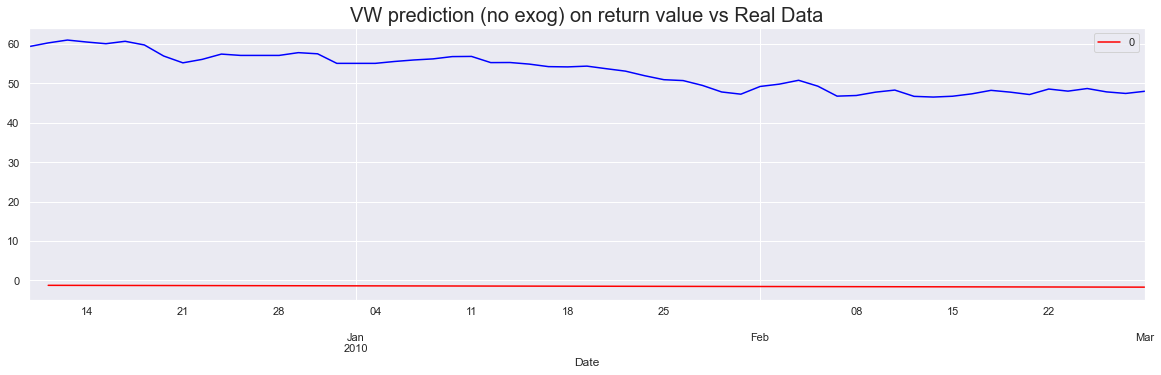

In [96]:
df_ret_pre_vol[date1:'2010-03-01'].plot(figsize=(20,5), color='red')
df.vol[date1:'2010-03-01'].plot(color='blue')
plt.title('VW prediction (no exog) on return value vs Real Data', size = 20)
plt.show()

#### with exogenous : POR

In [73]:
mod_pre_vol = auto_arima(df.vol[start_date:date1],
                         exogenous=df.por[start_date:date1],
                           m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend = 'ct')
mod_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -546.928
Date:                Sun, 13 Nov 2022   AIC                           1099.855
Time:                        17:57:46   BIC                           1109.384
Sample:                    04-06-2009   HQIC                          1103.720
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1446      1.105     -0.131      0.896      -2.311       2.022
drift         -0.0058      0.014     -0.404      0.686      -0.034       0.022
sigma2        28.2784      1.811     15.613      0.000      24.728      31.828
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               178.10
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [75]:
df_pre_vol = pd.DataFrame(mod_pre_vol.predict(n_periods=len(df[date1:date2]), exogenous=df.por[date1:date2]),
                          index=df[date1:date2].index)

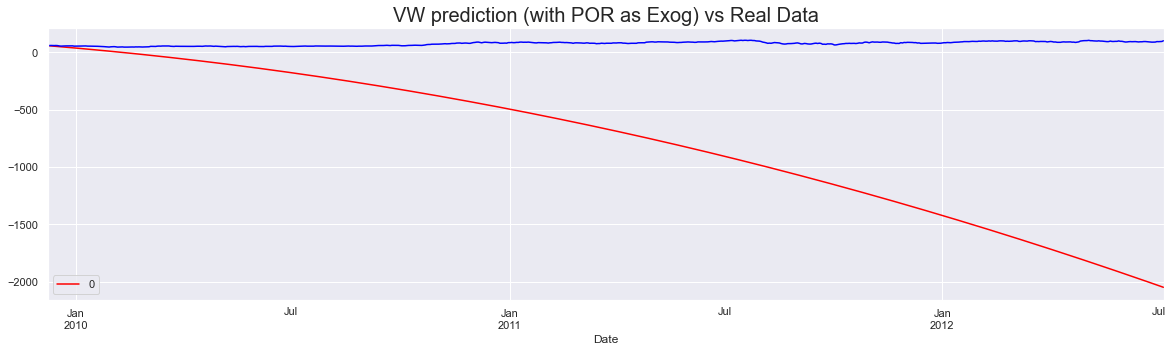

In [79]:
df_pre_vol[date1:date2].plot(figsize=(20,5), color='red')
df.vol[date1:date2].plot(color='blue')
plt.title('VW prediction (with POR as Exog) vs Real Data', size = 20)
plt.show()

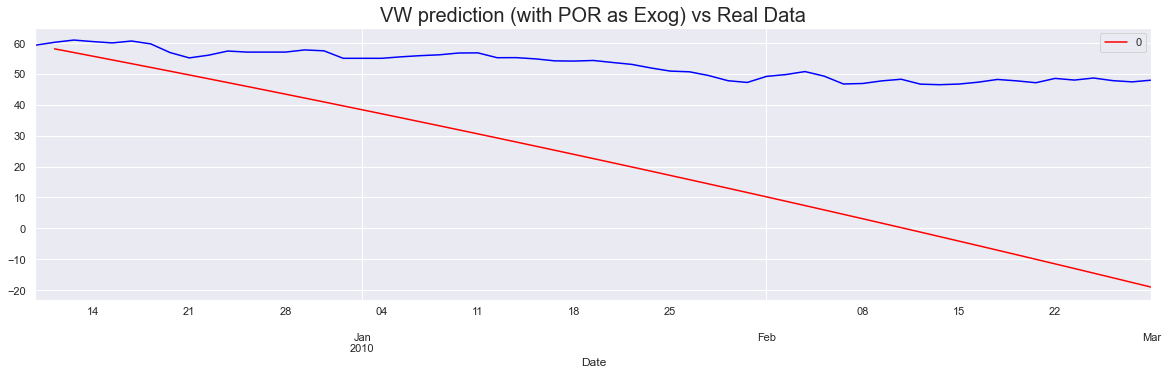

In [80]:
df_pre_vol[date1:'2010-03-01'].plot(figsize=(20,5), color='red')
df.vol[date1:'2010-03-01'].plot(color='blue')
plt.title('VW prediction (with POR as Exog) vs Real Data', size = 20)
plt.show()

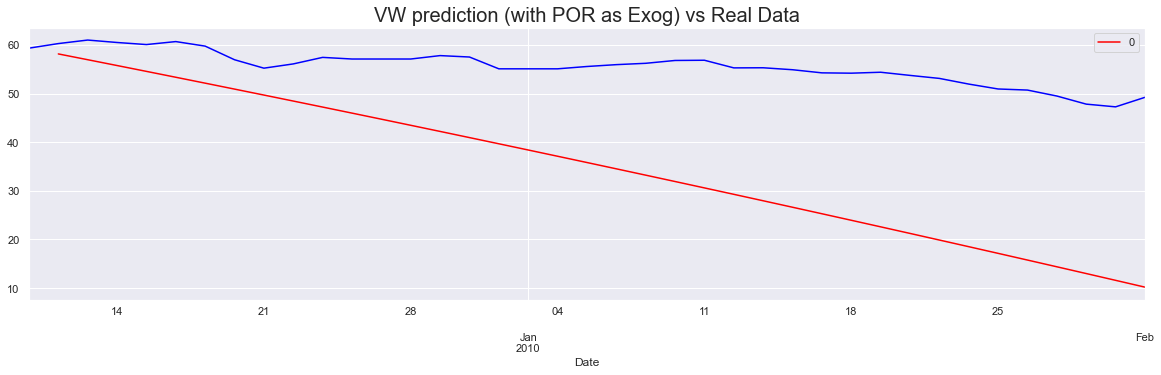

In [81]:
df_pre_vol[date1:'2010-02-01'].plot(figsize=(20,5), color='red')
df.vol[date1:'2010-02-01'].plot(color='blue')
plt.title('VW prediction (with POR as Exog) vs Real Data', size = 20)
plt.show()

#### with exogenous : POR & BMW 

In [82]:
mod_pre_vol_exog = auto_arima(df.vol[start_date:date1],
                         exogenous=df[['por','bmw']][start_date:date1],
                           m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend = 'ct')
mod_pre_vol_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -546.928
Date:                Sun, 13 Nov 2022   AIC                           1099.855
Time:                        18:10:54   BIC                           1109.384
Sample:                    04-06-2009   HQIC                          1103.720
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1446      1.105     -0.131      0.896      -2.311       2.022
drift         -0.0058      0.014     -0.404      0.686      -0.034       0.022
sigma2        28.2784      1.811     15.613      0.000      24.728      31.828
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               178.10
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
df_pre_vol_exog=pd.DataFrame(mod_pre_vol_exog.predict(n_periods=len(df[date1:date2]),exogenous=df[['por','bmw']][date1:date2]),
                          index=df[date1:date2].index)

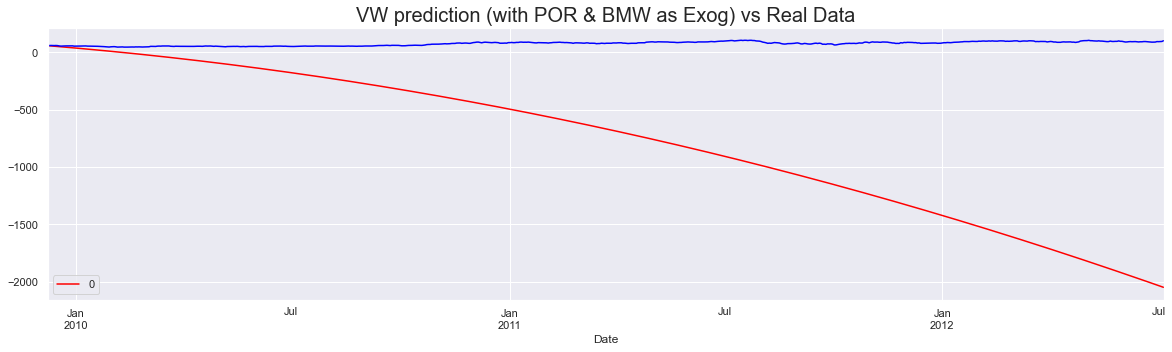

In [84]:
df_pre_vol[date1:date2].plot(figsize=(20,5), color='red')
df.vol[date1:date2].plot(color='blue')
plt.title('VW prediction (with POR & BMW as Exog) vs Real Data', size = 20)
plt.show()

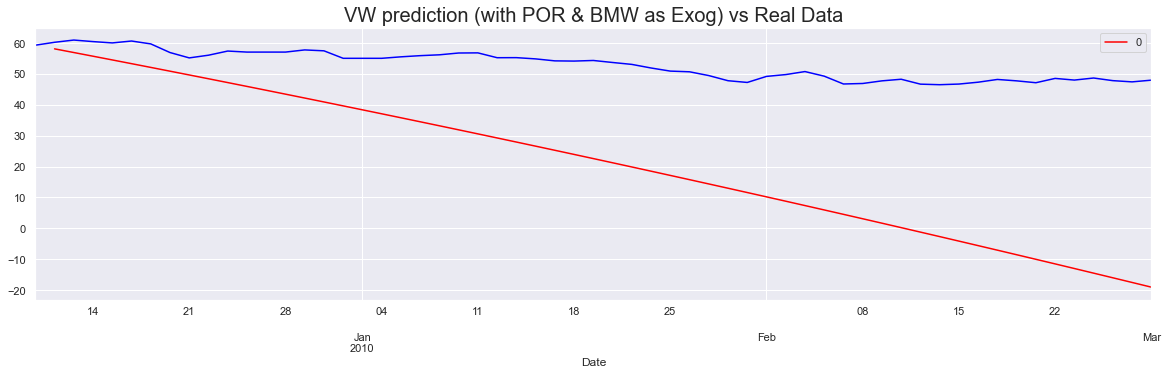

In [85]:
df_pre_vol[date1:'2010-03-01'].plot(figsize=(20,5), color='red')
df.vol[date1:'2010-03-01'].plot(color='blue')
plt.title('VW prediction (with POR & BMW as Exog) vs Real Data', size = 20)
plt.show()

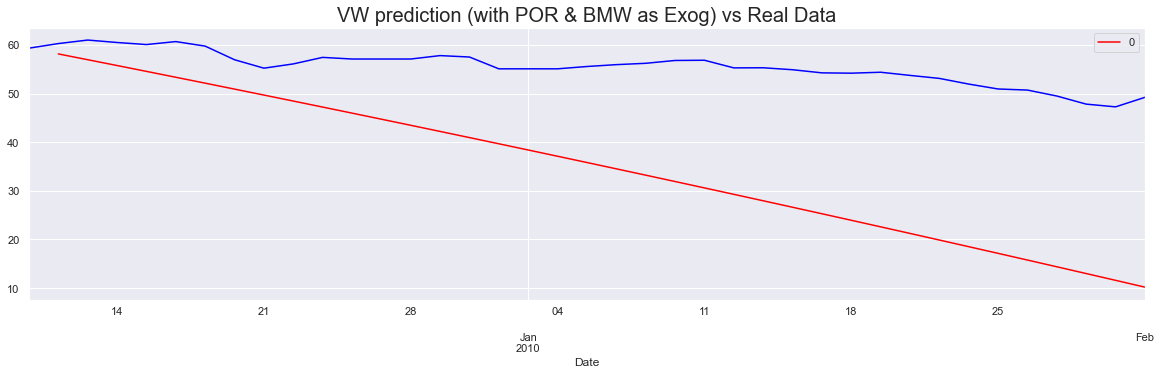

In [86]:
df_pre_vol[date1:'2010-02-01'].plot(figsize=(20,5), color='red')
df.vol[date1:'2010-02-01'].plot(color='blue')
plt.title('VW prediction (with POR & BMW as Exog) vs Real Data', size = 20)
plt.show()

### Volatility

#### Volatility of Volkswage for each periof

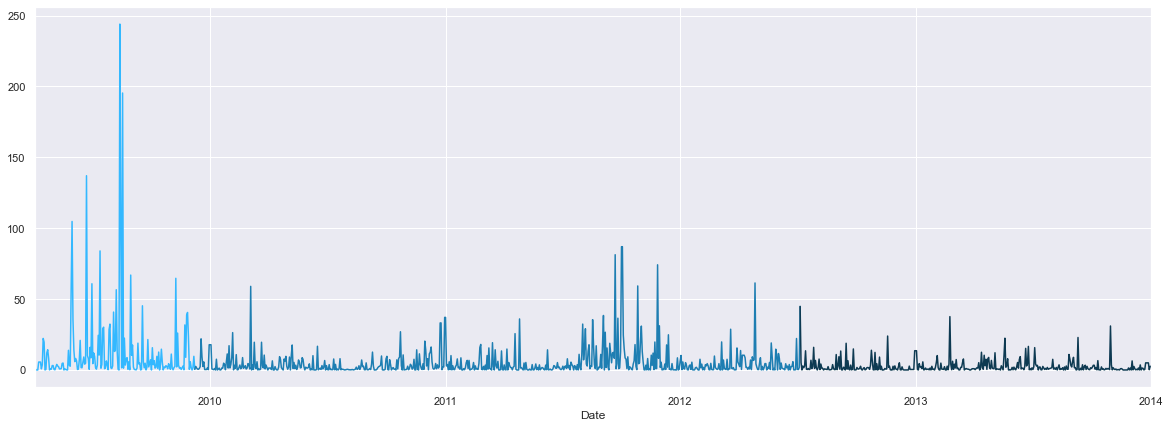

In [89]:
df['sq_ret_vol'][start_date:date1].plot(figsize=(20,7), color = '#33B8FF')
df['sq_ret_vol'][date1:date2].plot(color = '#1E7EB2')
df['sq_ret_vol'][date2:end_date].plot(color = '#0E3A52')
plt.show()

#### Volatality Trends for Each Period using Garch Model

In [100]:
model_garch_pre = arch_model(df.ret_vol[start_date:date1],
                            mean='Constant', vol='GARCH', p=1, q=1)
results_garch_pre = model_garch_pre.fit(update_freq = 5)
results_garch_pre.summary()

Iteration:      5,   Func. Count:     33,   Neg. LLF: 471.86753040734413
Iteration:     10,   Func. Count:     60,   Neg. LLF: 471.2399347665647
Optimization terminated successfully    (Exit mode 0)
            Current function value: 471.2399347668089
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -471.240
Distribution:                  Normal   AIC:                           950.480
Method:            Maximum Likelihood   BIC:                           963.207
                                        No. Observations:                  178
Date:                Sun, Nov 13 2022   Df Residuals:                      177
Time:                        18:27:17   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.3509      0.237     -1.479      0.139 [ -0.816,  0.114]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.9044      1.151      0.786      0.432    [ -1.351,  3.160]
alpha[1]       0.1027  8.423e-02      1.219      0.223 [-6.240e-02,  0.268]
beta[1]        0.8332      0.150      5.570  2.547e-08    [  0.540,  1.126]
===========================================================================

Covariance estimator: robust
"""

In [102]:
model_garch_btn = arch_model(df.ret_vol[date1:date2],
                             mean='Constant', vol='GARCH', p=1, q=1)
results_garch_btn = model_garch_btn.fit(update_freq = 5)
results_garch_btn.summary()

Iteration:      5,   Func. Count:     36,   Neg. LLF: 1457.3785547029447
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1457.3776208521012
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1457.38
Distribution:                  Normal   AIC:                           2922.76
Method:            Maximum Likelihood   BIC:                           2940.80
                                        No. Observations:                  672
Date:                Sun, Nov 13 2022   Df Residuals:                      671
Time:                        18:30:09   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1371  7.645e-02      1.793  7.299e-02 [-1.277e-02,  0.287]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1063  5.695e-02      1.867  6.192e-02 [-5.302e-03,  0.218]
alpha[1]       0.0678  1.702e-02      3.982  6.830e-05  [3.441e-02,  0.101]
beta[1]        0.9123  1.952e-02     46.738      0.000    [  0.874,  0.951]
===========================================================================

Covariance estimator: robust
"""

In [103]:
model_garch_post = arch_model(df.ret_vol[date2:end_date],
                            mean='Constant', vol='GARCH', p=1, q=1)
results_garch_post = model_garch_post.fit(update_freq = 5)
results_garch_post.summary()

Iteration:      5,   Func. Count:     33,   Neg. LLF: 735.53320215286
Optimization terminated successfully    (Exit mode 0)
            Current function value: 735.4576027273674
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -735.458
Distribution:                  Normal   AIC:                           1478.92
Method:            Maximum Likelihood   BIC:                           1494.78
                                        No. Observations:                  390
Date:                Sun, Nov 13 2022   Df Residuals:                      389
Time:                        18:30:43   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1856  8.659e-02      2.144  3.205e-02 [1.592e-02,  0.355]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.7863      0.694      1.132      0.257    [ -0.575,  2.147]
alpha[1]       0.0745      0.103      0.724      0.469    [ -0.127,  0.276]
beta[1]        0.6131      0.337      1.820  6.875e-02 [-4.712e-02,  1.273]
===========================================================================

Covariance estimator: robust
"""

### Forecast Volatilty

In [104]:
model_garch_pre = arch_model(df.ret_vol[start_date:date1],
                            mean='Constant', vol='GARCH', p=1, q=1)
results_garch_pre = model_garch_pre.fit(update_freq = 5)
results_garch_pre.summary()

Iteration:      5,   Func. Count:     33,   Neg. LLF: 471.86753040734413
Iteration:     10,   Func. Count:     60,   Neg. LLF: 471.2399347665647
Optimization terminated successfully    (Exit mode 0)
            Current function value: 471.2399347668089
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -471.240
Distribution:                  Normal   AIC:                           950.480
Method:            Maximum Likelihood   BIC:                           963.207
                                        No. Observations:                  178
Date:                Sun, Nov 13 2022   Df Residuals:                      177
Time:                        18:34:58   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.3509      0.237     -1.479      0.139 [ -0.816,  0.114]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.9044      1.151      0.786      0.432    [ -1.351,  3.160]
alpha[1]       0.1027  8.423e-02      1.219      0.223 [-6.240e-02,  0.268]
beta[1]        0.8332      0.150      5.570  2.547e-08    [  0.540,  1.126]
===========================================================================

Covariance estimator: robust
"""

In [121]:
pred_garch_pre = results_garch_pre.forecast(horizon=100, align='target')

<AxesSubplot:xlabel='Date'>

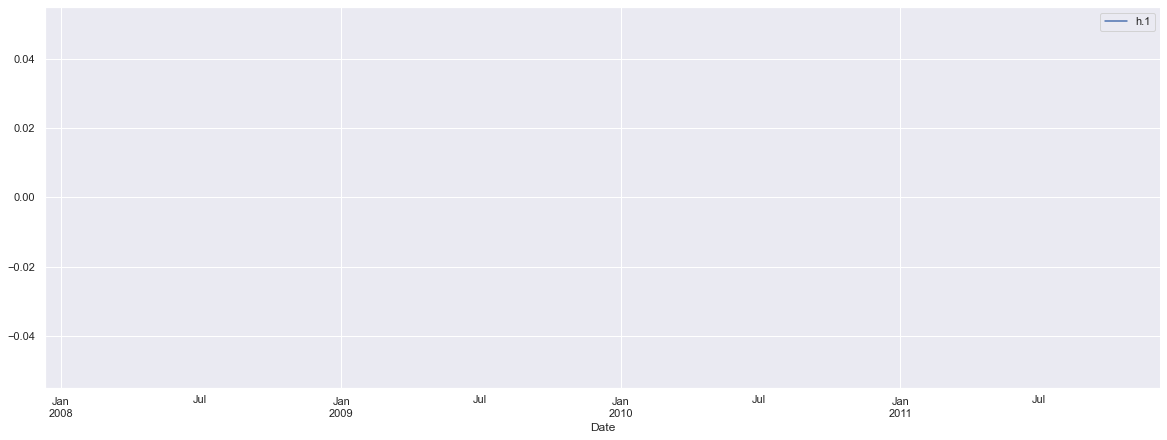

In [118]:
pred_garch.residual_variance[date1:date2].plot(figsize=(20,7))

In [122]:
pred_garch.residual_variance[-1:]

,h.1
Date,
2009-12-09,NaN
